# Global-Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import *
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
#import sys
#!{sys.executable} -m pip install geopy
import geopy.distance
from obspy.taup import TauPyModel

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [3]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime(2023,1,9,0,0),
                minmagnitude=7.0)
event_df = get_summary_data_frame(events)
print("Returned %s events" % len(events))

Returned 11 events


In [5]:
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
10,us7000j2yw,2023-01-08 12:32:42.368,Vanuatu,-14.9464,166.8808,29.000,7.0,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,768
9,us7000irfb,2022-11-22 02:03:06.891,"18 km SW of Malango, Solomon Islands",-9.8198,159.6033,14.000,7.0,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,768
8,us7000ip8h,2022-11-12 07:09:13.514,None,-20.1112,-178.3453,579.000,7.0,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,755
7,us7000ip0l,2022-11-11 10:48:46.710,"205 km ESE of Neiafu, Tonga",-19.2881,-172.1471,37.000,7.3,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,833
6,us7000ingi,2022-11-09 09:51:04.068,south of the Fiji Islands,-26.0901,178.3427,660.000,7.0,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,755
5,us7000i9bw,2022-09-19 18:05:08.217,"35 km SSW of Aguililla, Mexico",18.4552,-102.9561,26.943,7.6,yellow,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1799
4,us7000i7ya,2022-09-14 11:04:06.558,"209 km SSE of Isangel, Vanuatu",-21.1909,170.2666,137.000,7.0,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,761
3,us6000iitd,2022-09-10 23:47:00.233,"70 km E of Kainantu, Papua New Guinea",-6.2944,146.5038,116.000,7.6,yellow,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,965
2,us6000i5rd,2022-07-27 00:43:26.871,"11 km NE of Bantay, Philippines",17.5207,120.8181,33.729,7.0,yellow,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1351
1,us7000hcmn,2022-05-26 12:02:21.110,"10 km W of Azángaro, Peru",-14.9076,-70.2924,236.000,7.2,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,876


In [7]:
dist_kmarray = []
magnituddarray = []

### Choose an event to analyze

In [8]:
for index,this_event in event_df.iterrows():
    
    this_id = this_event['id']
    
    this_event_new = event_df[event_df.id==this_id]
    
    coords_1 = (this_event_new.latitude.to_numpy()[0], this_event_new.longitude.to_numpy()[0])
    coords_2 = (47.6531, -122.3079)
    dist_km = geopy.distance.geodesic(coords_1, coords_2).km
    dist_kmarray.append(dist_km)
    
    dist_deg = dist_km / 40075 * 360
    magnituddarray.append(this_event_new['magnitude'].to_numpy()[0])

    model = TauPyModel(model="iasp91")
    arrivals = model.get_travel_times(source_depth_in_km=this_event_new.depth.to_numpy()[0],
                                  distance_in_degree=dist_deg)
    print(f'Distance = {dist_deg} deg\nArrival time = {arrivals[0].time} s after source time.')
    t0 = this_event_new['time'].iloc[0]
    t0 = t0 + datetime.timedelta(seconds=arrivals[0].time) # Correct for travel time
    t0 = t0 - datetime.timedelta(minutes=5) # Get one minute of data before the first arrival
    print(this_event['id'])
    
    stitle=f"M {this_event_new['magnitude'].to_numpy()[0]}, "\
               f"{this_event_new['location'].to_numpy()[0]}, "\
               f"{str(this_event_new['time'].to_numpy()[0])[0:-10]} UTC"
    #cable = 'seadasn'
    cable = 'whidbey'
    record_length = 35 #minutes
    
    

    prefix, network_name, datastore = data_wrangler(cable,record_length,t0)
    try:
        data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
        x_max=data.shape[1] * attrs['SpatialSamplingInterval']
        low_cut = 0.01
        hi_cut = 1

        b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
        data_filt = filtfilt(b,a,data,axis=0)
    
        client = Client("IRIS")

        t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
        dt = datetime.timedelta(minutes=record_length)
        t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

        st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
        # st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
        st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

        pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
        st.remove_response(output='VEL', pre_filt=pre_filt)
        st2.remove_response(output='VEL', pre_filt=pre_filt)
    
        filename = f"globalearthquakestestW/"+this_id
        local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                                        stitle,filename=filename,das_vmax=5,
                                        network_name=network_name,
                                        skip_seismograms=False)
    except ValueError:
        continue

Distance = 88.45926849336227 deg
Arrival time = 769.4583667539646 s after source time.
us7000j2yw
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-40*h5
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-41*h5
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-42*h5
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-43*h5
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-44*h5
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-45*h5
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-46*h5
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-47*h5
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-48*h5
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-49*h5
Searching for files matching: /data/data6/whidbey/whidbey_2023-01-08_12-50*h5
Searching for files matching: /data/data6/wh

Searching for files matching: /data/data6/whidbey/whidbey_2022-11-12_07-47*h5
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-12_07-48*h5
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-12_07-49*h5
Distance = 80.17304562457764 deg
Arrival time = 726.4142343217551 s after source time.
us7000ip0l
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-11_10-55*h5
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-11_10-56*h5
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-11_10-57*h5
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-11_10-58*h5
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-11_10-59*h5
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-11_11-00*h5
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-11_11-01*h5
Searching for files matching: /data/data6/whidbey/whidbey_2022-11-11_11-02*h5
Searching for files matching: /data/data6/wh

Searching for files matching: /data/data5/Converted/whidbey_2022-09-19_18-34*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-09-19_18-35*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-09-19_18-36*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-09-19_18-37*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-09-19_18-38*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-09-19_18-39*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-09-19_18-40*h5
Distance = 91.24281258348374 deg
Arrival time = 769.6104660983981 s after source time.
us7000i7ya
Searching for files matching: /data/data5/Converted/whidbey_2022-09-14_11-11*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-09-14_11-12*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-09-14_11-13*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-09-14_11-14*h5
Searching for files ma

Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-13*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-14*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-15*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-16*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-17*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-18*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-19*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-20*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-21*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-22*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-23*h5
Searching for files matching: /data/data5/Converted/whidbey_2022-07-27_01-24*h5
Searching for files matching: /data/data

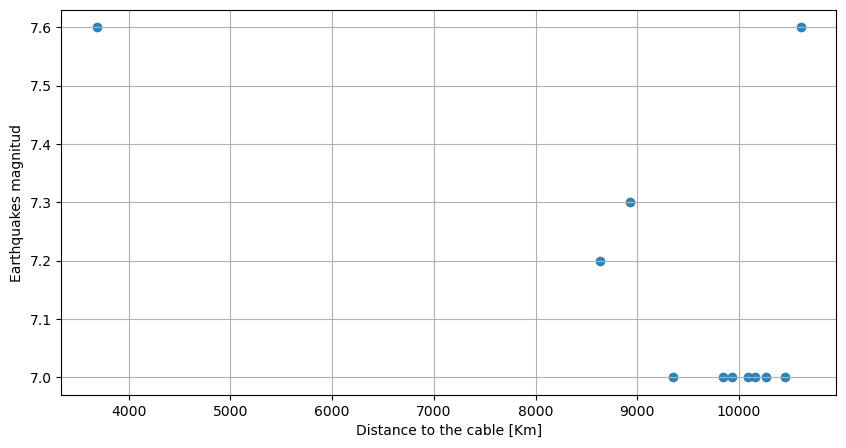

In [9]:
#creating plot distance vs magnitud
plt.subplots(figsize=(10,5))
plt.scatter(dist_kmarray, magnituddarray,s=None, marker='o', alpha=0.9, label='Different earthquakes')
plt.xlabel('Distance to the cable [Km]')
plt.ylabel('Earthquakes magnitud');
plt.grid()
plt.show()

In [ ]:
variable4=np.zeros(5)
for i in range(len(variable4)):
    variable4[i] = 2*i**2 - i + 4
plt.plot(variable4)

### Calculate arrival times

### Load the DAS Data

Catalog

In [ ]:
tf=['True','True','True','True','True','True','True','True','True','True','True','True']
tfn=np.array(tf).T
dataf = np.array([this_event.id, this_event.location, this_event.magnitude,tf]).T

df3 = pd.DataFrame(dataf,columns=['Id', 'Distance', 'Magnitude','Detected by Das_W'])
df3